# Setting Observation Points

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import pyPoseidon.grid as pgrid
import pyPoseidon.dem as pdem
from pyPoseidon.utils import *

In [3]:
%matplotlib notebook

In [4]:
ofilename='/Users/brey/DATA/OBS/thomas.txt'
ofilename='/Users/brey/DATA/OBS/eu.csv'

In [5]:
obs_points = pd.read_csv(ofilename,delimiter='\t',header=None,names=['index','Name','lat','lon'])

In [6]:
obs_points = obs_points.set_index('index',drop=True).reset_index(drop=True) #reset index if any

In [7]:
obs_points.head()

,Name,lat,lon
0,Aberdeen,57.14325,-2.07451
1,AJACCIO_ASPRETTO,41.92280,8.76280
2,alcudia,39.83470,3.13920
3,Alexandria,31.21170,29.92330
4,algeciras,36.17690,-5.39830


In [8]:
#read grid
grid = pgrid.r2d.read_file('/Users/brey/Downloads/EUR/D3D/ERAI/201701/gebco_eur_01.grd')

In [9]:
grid

<xarray.Dataset>
Dimensions:  (x: 70, y: 50)
Coordinates:
  * y        (y) float64 41.0 41.1 41.2 41.31 41.41 41.51 41.61 41.71 41.82 ...
  * x        (x) float64 11.0 11.1 11.2 11.3 11.41 11.51 11.61 11.71 11.81 ...
Data variables:
    lons     (y, x) float64 11.0 11.1 11.2 11.3 11.41 11.51 11.61 11.71 ...
    lats     (y, x) float64 41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 ...
Attributes:
    Coordinate System:  Spherical
    xori:               0.0
    yori:               0.0
    alfori:             0.0

In [22]:
grid.lons.values.min(),grid.lons.max().values

(11.0, array(18.))

In [25]:
obs_points = obs_points[(obs_points.lon.between(grid.lons.values.min(),grid.lons.values.max())) & (obs_points.lat.between(grid.lats.values.min(),grid.lats.values.max()))]

In [26]:
# obs point
lat, lon = obs_points.loc[0,['lat','lon']]

lat,lon

(44.96, 12.49)

In [27]:
#nearest values in grid
nearest = grid.sel(x=[lon],y=[lat], method='nearest')
nearest

<xarray.Dataset>
Dimensions:  (x: 1, y: 1)
Coordinates:
  * y        (y) float64 44.98
  * x        (x) float64 12.52
Data variables:
    lons     (y, x) float64 12.52
    lats     (y, x) float64 44.98
Attributes:
    Coordinate System:  Spherical
    xori:               0.0
    yori:               0.0
    alfori:             0.0

In [28]:
#... correspondinh indices
j = np.abs(grid.x.values-nearest.x.values).argmin()
i = np.abs(grid.y.values-nearest.y.values).argmin()
i,j

(39, 15)

In [29]:
#check
grid.lons[i,j]

<xarray.DataArray 'lons' ()>
array(12.521739)
Coordinates:
    y        float64 44.98
    x        float64 12.52

## Check with DEM

In [31]:
rdem = np.loadtxt('/Users/brey/Downloads/EUR/D3D/ERAI/201701/gebco_eur_01.dep')

In [32]:
dem = xr.Dataset({'ival': (['ilat', 'ilon'],  rdem[:-1,:-1]), 
                    'ilons': (['k', 'l'], grid.lons.values),   
                    'ilats': (['k', 'l'], grid.lats.values)}, 
                    coords={'ilon': ('ilon', grid.x.values),   
                            'ilat': ('ilat', grid.y.values)})         
            



In [33]:
dem

<xarray.Dataset>
Dimensions:  (ilat: 50, ilon: 70, k: 50, l: 70)
Coordinates:
  * ilat     (ilat) float64 41.0 41.1 41.2 41.31 41.41 41.51 41.61 41.71 ...
  * ilon     (ilon) float64 11.0 11.1 11.2 11.3 11.41 11.51 11.61 11.71 ...
Dimensions without coordinates: k, l
Data variables:
    ival     (ilat, ilon) float64 1.866e+03 1.63e+03 1.481e+03 1.919e+03 ...
    ilats    (k, l) float64 41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 41.0 ...
    ilons    (k, l) float64 11.0 11.1 11.2 11.3 11.41 11.51 11.61 11.71 ...

In [34]:
dem.ival

<xarray.DataArray 'ival' (ilat: 50, ilon: 70)>
array([[1866., 1630., 1481., ...,  167.,  262.,  436.],
       [1078., 1486., 1604., ...,  858.,  946.,  974.],
       [1236., 1110., 1528., ..., 1037., 1073., 1077.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])
Coordinates:
  * ilat     (ilat) float64 41.0 41.1 41.2 41.31 41.41 41.51 41.61 41.71 ...
  * ilon     (ilon) float64 11.0 11.1 11.2 11.3 11.41 11.51 11.61 11.71 ...

In [35]:
b=np.ma.masked_array(dem.ival.values,dem.ival.values == -999.) # mask land

In [36]:
b

masked_array(
  data=[[1866.0, 1630.0, 1481.0, ..., 167.0, 262.0, 436.0],
        [1078.0, 1486.0, 1604.0, ..., 858.0, 946.0, 974.0],
        [1236.0, 1110.0, 1528.0, ..., 1037.0, 1073.0, 1077.0],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [37]:
plt.figure()
plt.contourf(dem.ilons,dem.ilats,b)
plt.plot(nearest.x.values,nearest.y.values,marker='x',markersize=10,color='r')

<IPython.core.display.Javascript object>

In [21]:
b[i,j]

masked

## Find the nearest valid point

In [26]:
# get a wide area around the original i,j
bnear=b[i-5:i+6,j-5:j+6]
bnear

masked_array(
  data=[[--, --, --, --, --, 20.0, 28.0, 32.0, 37.0, 41.0, 41.0],
        [--, --, --, --, --, 22.0, 29.0, 32.0, 36.0, 39.0, 41.0],
        [--, --, --, --, --, 23.0, 28.0, 31.0, 34.0, 36.0, 39.0],
        [--, --, --, --, --, 15.0, 26.0, 30.0, 33.0, 35.0, 37.0],
        [--, --, --, --, --, --, --, 29.0, 32.0, 34.0, 35.0],
        [--, --, --, --, --, --, --, 30.0, 32.0, 33.0, 34.0],
        [--, --, --, --, --, --, --, 30.0, 31.0, 33.0, 33.0],
        [--, --, --, --, --, 24.0, 26.0, 26.0, 27.0, 30.0, 32.0],
        [--, --, --, --, --, 19.0, 23.0, 25.0, 27.0, 30.0, 32.0],
        [--, --, --, --, --, 15.0, 19.0, 20.0, 22.0, 26.0, 28.0],
        [--, --, --, --, --, --, --, --, 18.0, 22.0, 22.0]],
  mask=[[ True,  True,  True,  True,  True, False, False, False, False,
         False, False],
        [ True,  True,  True,  True,  True, False, False, False, False,
         False, False],
        [ True,  True,  True,  True,  True, False, False, False, False,
         Fals

In [27]:
#get a corresponding area of lats,lons and substract the lon,lat of the obs point to get distance
rlon = grid.lons[i-5:i+6,j-5:j+6]-lon
rlat = grid.lats[i-5:i+6,j-5:j+6]-lat

rad = np.sqrt(rlon**2+rlat**2) # radial distance from the obs point

In [28]:
#mask the distance array with the valid mask from dem
rmask = rad.values[bnear.mask==False]

In [29]:
rmask.sort() #sort values in order to start from closer point

In [30]:
rmask

array([0.17400013, 0.17428059, 0.18607094, 0.18616742, 0.21486516,
       0.23085386, 0.24008301, 0.24294195, 0.27334305, 0.27354007,
       0.28118103, 0.28126278, 0.28642319, 0.30102738, 0.3216538 ,
       0.32166945, 0.3305187 , 0.33702961, 0.35565249, 0.37146649,
       0.37314166, 0.37326487, 0.3789209 , 0.37896075, 0.38459279,
       0.39385274, 0.40984598, 0.40985295, 0.42712738, 0.43042957,
       0.43544915, 0.43702538, 0.46088405, 0.46090117, 0.46261686,
       0.47310767, 0.47316087, 0.47766703, 0.47767899, 0.48956565,
       0.49693087, 0.50252191, 0.50256901, 0.50839434, 0.5249245 ,
       0.52624365, 0.5449483 , 0.54500097, 0.56830212, 0.57575588,
       0.59545755, 0.60123783, 0.60127244, 0.63837437, 0.64735786,
       0.66789453, 0.70966664])

In [31]:
for r in rmask: # Find the closest valid point
    [[k,l]] = np.argwhere(rad.values==r)
    #print bnear[k-1:k+1,l-1:l+1].mask.sum()
    if bnear[k-1:k+1,l-1:l+1].mask.sum() == 0:
            print k,l
            break# the indices of the closest valid point

3 6


In [32]:
rad[k,l] # the x,y gives us the lon,lat of the valid point

<xarray.DataArray ()>
array(0.186071)
Coordinates:
    y        float64 44.79
    x        float64 12.56

In [33]:
xv = rad[k,l].x.values
yv = rad[k,l].y.values

In [34]:
bnear[k,l] # check

26.0

In [35]:
#final i,j
j = np.abs(grid.x.values-xv).argmin()

i = np.abs(grid.y.values-yv).argmin()

i,j

(197, 475)

In [36]:
#check
grid.lons[i,j], grid.lats[i,j]

(<xarray.DataArray 'lons' ()>
 array(12.561769)
 Coordinates:
     y        float64 44.79
     x        float64 12.56, <xarray.DataArray 'lats' ()>
 array(44.788327)
 Coordinates:
     y        float64 44.79
     x        float64 12.56)

<IPython.core.display.Javascript object>


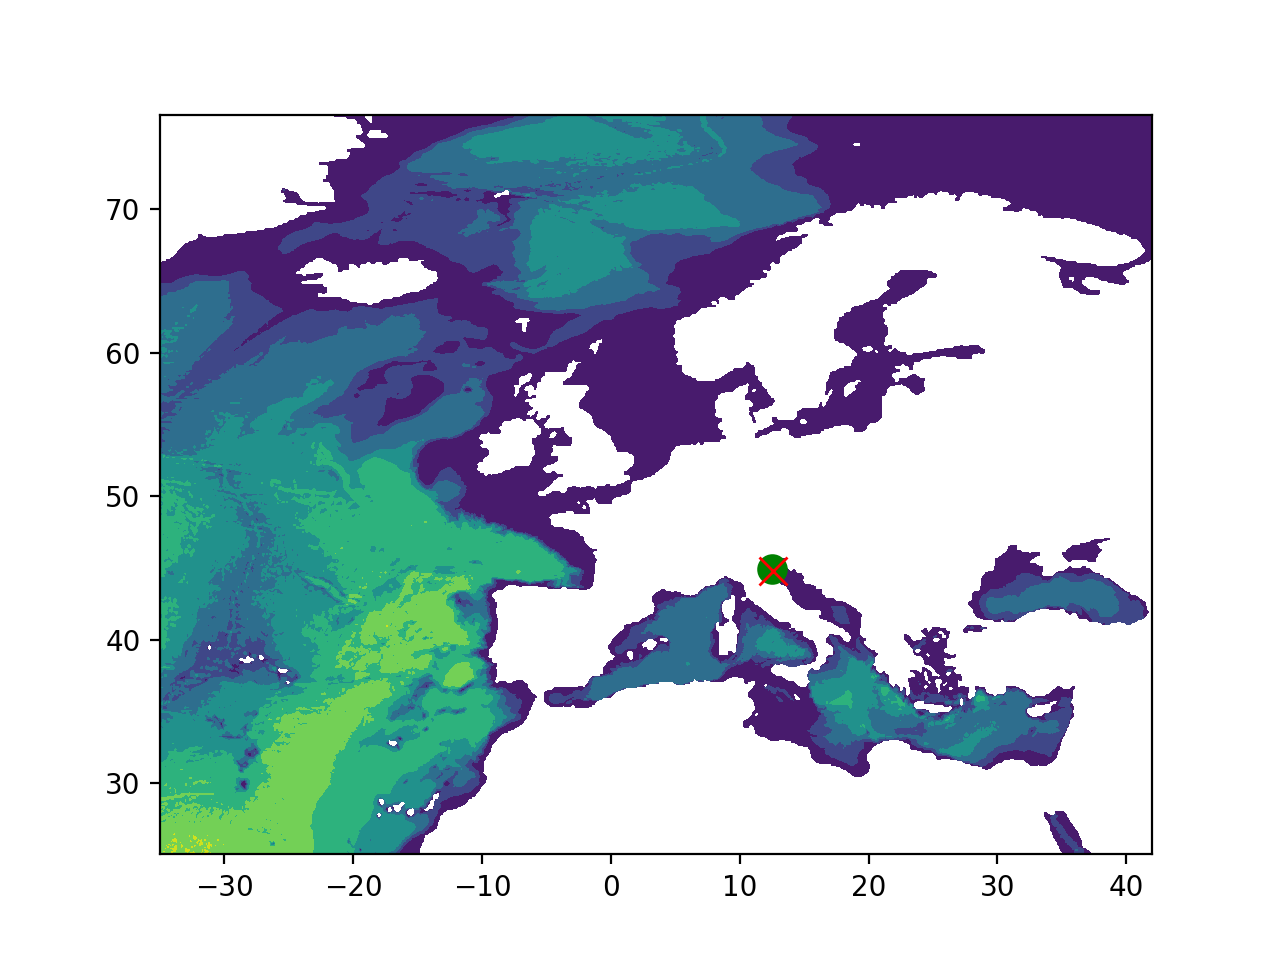

In [37]:
#on map
plt.figure()
plt.contourf(dem.ilons,dem.ilats,b)
plt.plot(lon,lat,marker='o',markersize=10,color='g')
plt.plot(xv,yv,marker='x',markersize=10,color='r')

## Function

In [38]:
idx=[]
jdx=[]
for m in range(obs_points.shape[0]):
    lat, lon = obs_points.loc[m,['lat','lon']]
    nearest = grid.sel(x=[lon],y=[lat], method='nearest')
    j = np.abs(grid.x.values-nearest.x.values).argmin()
    i = np.abs(grid.y.values-nearest.y.values).argmin()
    if b[i,j] :
        idx.append(i) 
        jdx.append(j) 
    else:
        bnear=b[i-5:i+6,j-5:j+6] # near by grid nodes
        
        rlon = grid.lons[i-5:i+6,j-5:j+6]-lon
        rlat = grid.lats[i-5:i+6,j-5:j+6]-lat
        rad = np.sqrt(rlon**2+rlat**2) # radial distance from the obs point
        
        rmask = rad.values[bnear.mask==False] #mask the distance array with the valid mask from dem
        rmask.sort()
        if rmask.size > 0 :
            
            for r in rmask: # Find the closest valid point
                [[k,l]] = np.argwhere(rad.values==r)
                if bnear[k-1:k+1,l-1:l+1].mask.sum() == 0:
                    break# the indices of the closest valid point

            xv = rad[k,l].x.values #lat, lon of valid point
            yv = rad[k,l].y.values
        
            #final i,j
            j = np.abs(grid.x.values-xv).argmin()
            i = np.abs(grid.y.values-yv).argmin()

            idx.append(i) 
            jdx.append(j) 
          
        else:
            
            idx.append(np.nan)
            jdx.append(np.nan)


In [39]:
obs_points['i']=idx
obs_points['j']=jdx

In [40]:
obs_points.head()

,Name,lat,lon,i,j
0,Po Della Pila,44.96,12.49,197.0,475.0
1,Madonna Del Ponte,43.83,13.05,190.0,482.0
2,Martinsicuro,42.84,13.93,179.0,491.0
3,Aries,43.34,4.84,182.0,398.0
4,El Foix,41.20,1.67,161.0,366.0


In [41]:
#drop NaN points
obs = obs_points.dropna().copy()

In [42]:
obs = obs.reset_index(drop=True)

In [43]:
obs['i']=obs['i'].values.astype(int)

obs['j']=obs['j'].values.astype(int)

obs['new_lat']=grid.y[obs.i.values].values 

obs['new_lon']=grid.x[obs.j.values].values 

In [44]:
obs.head()

,Name,lat,lon,i,j,new_lat,new_lon
0,Po Della Pila,44.96,12.49,197,475,44.788327,12.561769
1,Madonna Del Ponte,43.83,13.05,190,482,44.086965,13.262679
2,Martinsicuro,42.84,13.93,179,491,42.984825,14.163849
3,Aries,43.34,4.84,182,398,43.285409,4.851756
4,El Foix,41.20,1.67,161,366,41.181323,1.647594


<IPython.core.display.Javascript object>


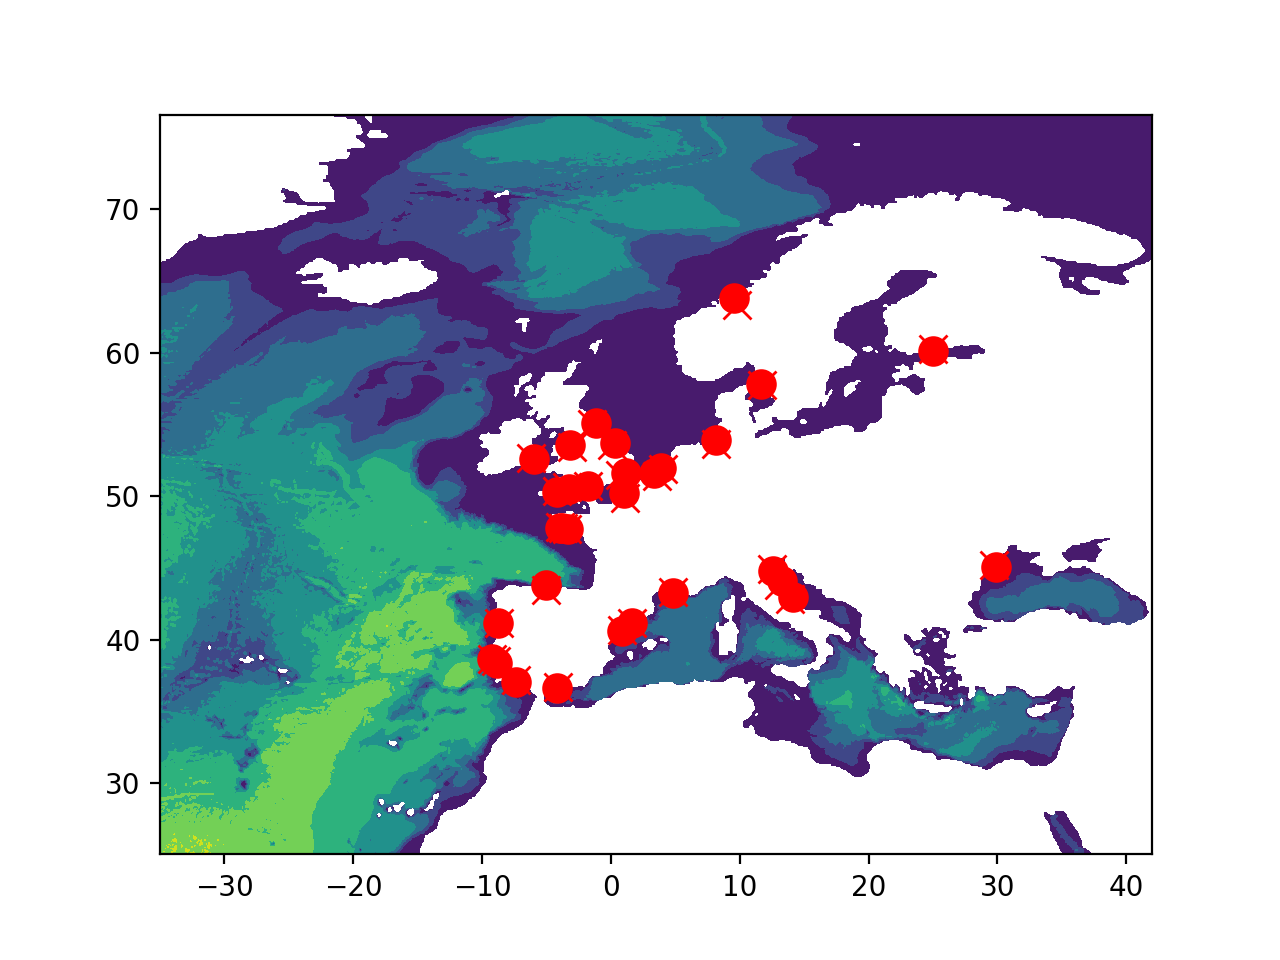

In [45]:
#on map
plt.figure()
plt.contourf(dem.ilons,dem.ilats,b)
plt.plot(obs.lon,obs.lat,marker='x',markersize=10,color='r',linestyle='None')
plt.plot(obs.new_lon,obs.new_lat,marker='o',markersize=10,color='r',linestyle='None')

## save D3D obs file

In [40]:
obs.Name = obs.Name.str.strip().apply(lambda name:name.replace(' ', '')) #Remove spaces to write to file

In [41]:
sort = sorted(obs.Name.values,key=len) # sort the names to get the biggest word

In [42]:
wsize = len(sort[-1])# size of bigget word in order to align below
wsize

20

In [43]:
# Add one in the indices due to python/fortran convention
with open('/Users/brey/Downloads/EUR/D3D/ERAI/eur01.obs','w') as f:
    for l in range(obs.shape[0]): 
        f.write('{0:<{3}}{1:>{3}}{2:>{3}}\n'.format(obs.Name[l],obs.j[l]+1,obs.i[l]+1,wsize))


## Validate

### Read obs data

In [7]:
trih = xr.open_dataset('/Users/brey/Downloads/EUR/D3D/ERAI/trih-eur01.nc')
trih

<xarray.Dataset>
Dimensions:        (KMAXOUT: 2, KMAXOUT_RESTR: 1, NOSTAT: 31, SIG_INTF: 2, SIG_LYR: 1, length_2: 2, time: 1441)
Coordinates:
    NAMST          (NOSTAT) |S20 ...
  * SIG_LYR        (SIG_LYR) float32 -0.5
  * SIG_INTF       (SIG_INTF) float32 0.0 -1.0
  * KMAXOUT        (KMAXOUT) int32 0 1
  * KMAXOUT_RESTR  (KMAXOUT_RESTR) int32 0
  * time           (time) datetime64[ns] 2017-02-01 2017-02-01T00:01:00 ...
    XSTAT          (time, NOSTAT) float64 ...
    YSTAT          (time, NOSTAT) float64 ...
Dimensions without coordinates: NOSTAT, length_2
Data variables:
    ALFAS          (NOSTAT) float32 ...
    ZKFS           (time, NOSTAT) int32 ...
    ZWL            (time, NOSTAT) float32 ...
    ZCURU          (time, KMAXOUT_RESTR, NOSTAT) float32 ...
    ZCURV          (time, KMAXOUT_RESTR, NOSTAT) float32 ...
    ZQXK           (time, KMAXOUT_RESTR, NOSTAT) float32 ...
    ZQYK           (time, KMAXOUT_RESTR, NOSTAT) float32 ...
    ZTAUKS         (time, NOSTAT) float32 .

In [8]:
trih.DPS[:,0]

<xarray.DataArray 'DPS' (time: 1441)>
array([28., 28., 28., ..., 28., 28., 28.], dtype=float32)
Coordinates:
    NAMST    |S20 ...
  * time     (time) datetime64[ns] 2017-02-01 2017-02-01T00:01:00 ...
    XSTAT    (time) float64 ...
    YSTAT    (time) float64 ...
Attributes:
    long_name:  Depth in station
    units:      m

In [9]:
xh,yh = trih.XSTAT[0,0].values,trih.YSTAT[0,0].values

<IPython.core.display.Javascript object>


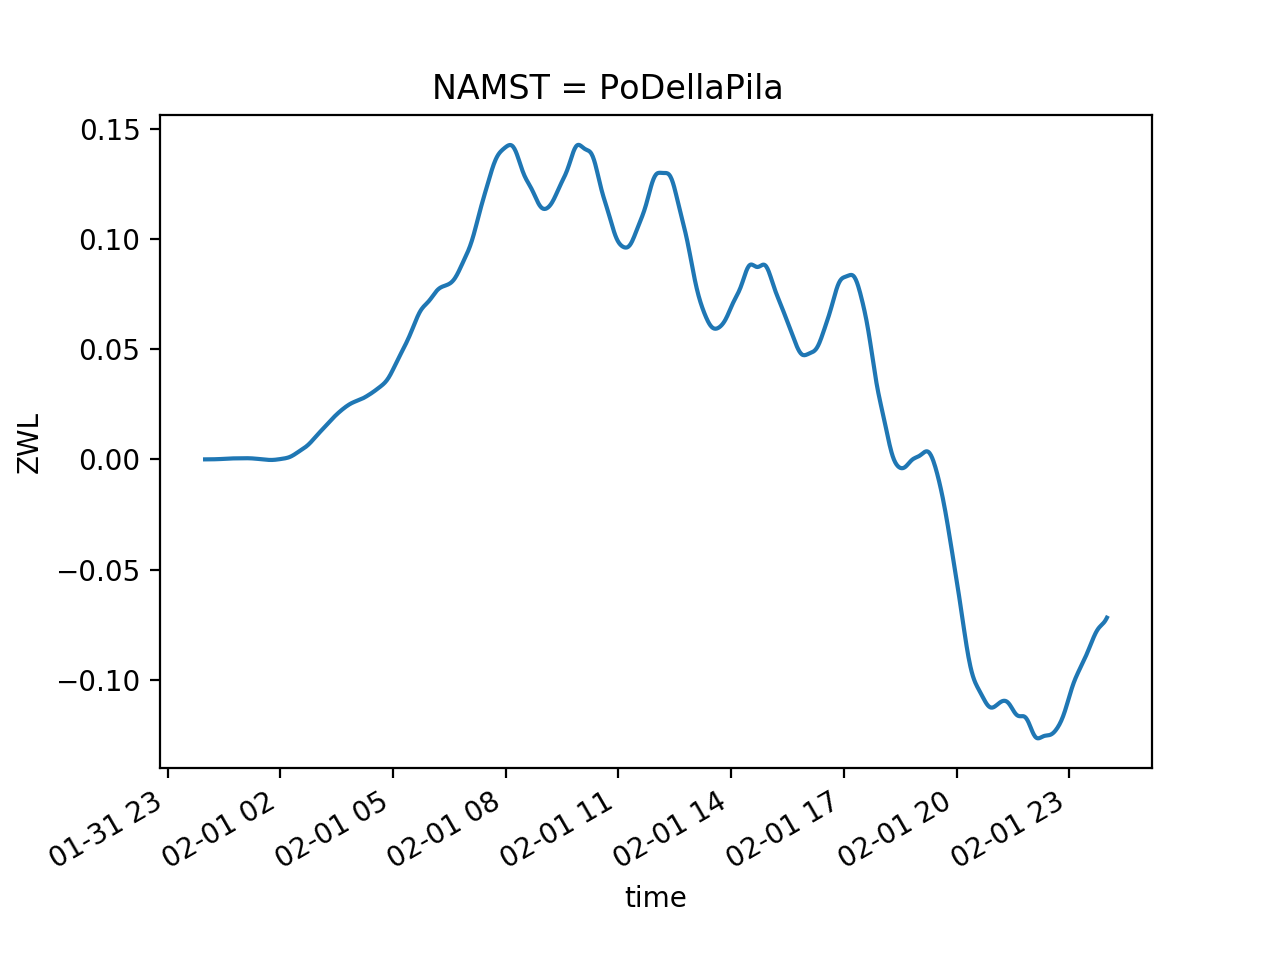

In [10]:
trih.ZWL[:,0].plot()

### Read map data

In [46]:
im,jm = obs.loc[0,['i','j']]
im, jm

(197, 475)

In [47]:
trim = xr.open_dataset('/Users/brey/Downloads/EUR/D3D/ERAI/trim-eur01.nc')

In [48]:
trim.XCOR[jm,im], trim.YCOR[jm,im]

(<xarray.DataArray 'XCOR' ()>
 array(12.561769)
 Coordinates:
     XCOR     float64 ...
     YCOR     float64 ...
 Attributes:
     standard_name:  longitude
     long_name:      X-coordinate of grid points
     units:          degrees_east, <xarray.DataArray 'YCOR' ()>
 array(44.788327)
 Coordinates:
     XCOR     float64 ...
     YCOR     float64 ...
 Attributes:
     standard_name:  laitude
     long_name:      Y-coordinate of grid points
     units:          degrees_north)

In [49]:
xz,yz = trim.XZ[jm,im].values, trim.YZ[jm,im].values

In [50]:
# compare with the obs dataset
xh,yh,xz,yz

(array(12.51170351),
 array(44.73822957),
 array(12.51170351),
 array(44.73822957))

In [51]:
#The values every hour of the obs dataset should be the same as the map data
np.array_equal(trim.S1[:,jm,im].values,trih.ZWL[::60,0].values)

True

<IPython.core.display.Javascript object>


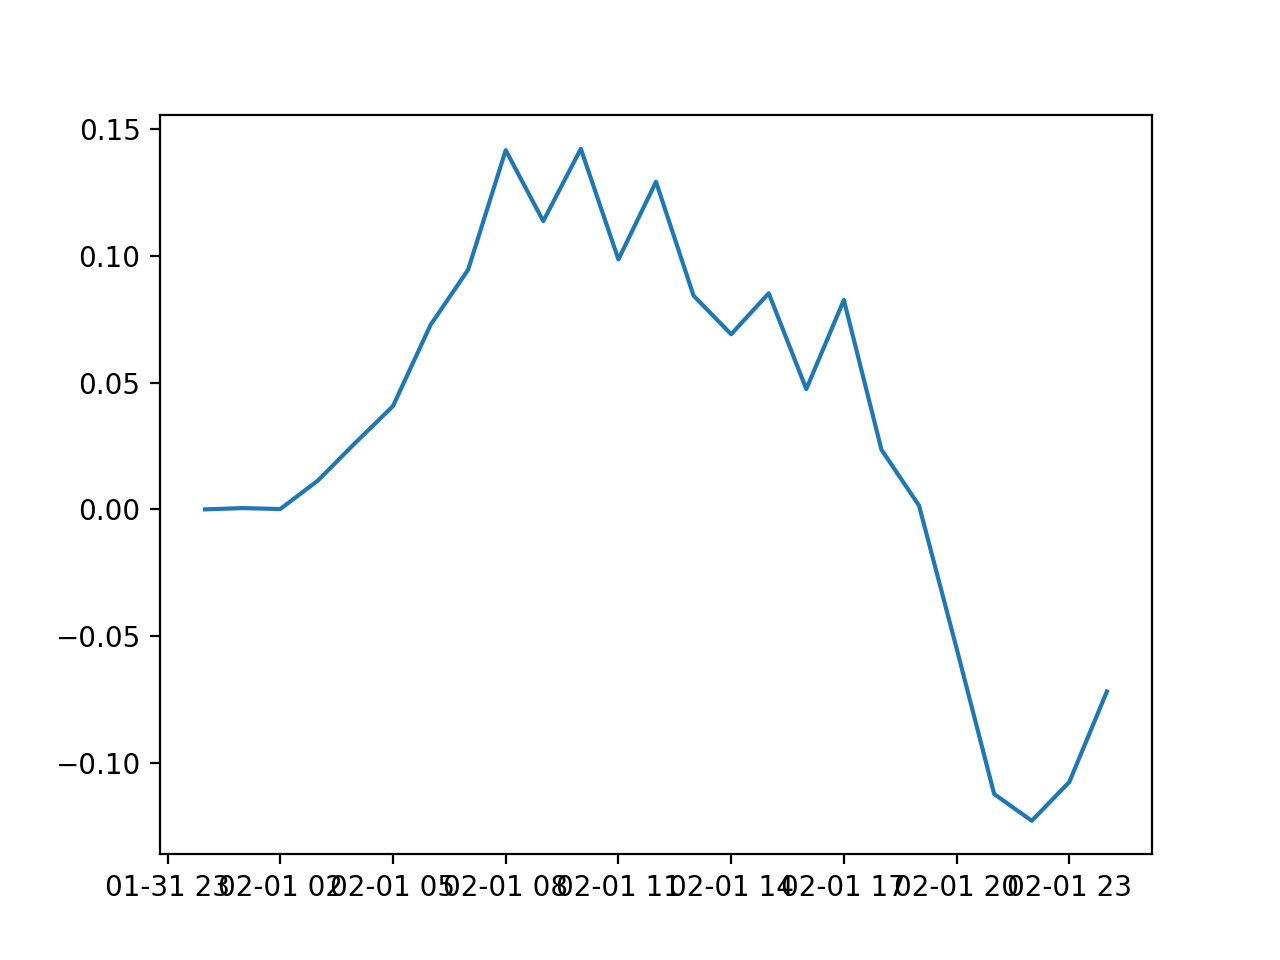

In [52]:
v = trim.S1[:,jm, im] 
plt.figure()
plt.plot(v.time,v.values)

## using data class

In [53]:
otp = data(**{'rpath':'/Users/brey/Downloads/EUR/D3D/ERAI/','solver':'d3d'})#,tag='eur025')


reading data based on /Users/brey/Downloads/EUR/D3D/ERAI/eur01_info.pkl 


In [54]:
otp.impl.Dataset.S1.shape

(25, 514, 769)

In [56]:
lot = otp.impl.Dataset.S1[:,im-1, jm-1].values # minus -1 due to the ghost values

In [57]:
np.array_equal(trim.S1[:,jm,im].values,lot)

True

In [58]:
## get the resampled data for the original obs point

In [59]:
lat,lon = obs.loc[0,['lat','lon']]

In [60]:
ts = point(lon=lon,lat=lat,data=otp.impl)
ts.tseries(var='S1')

In [61]:
ts.S1.head()

,S1
time,
2017-02-01 00:00:00,0.000000
2017-02-01 01:00:00,0.001293
2017-02-01 02:00:00,0.003235
2017-02-01 03:00:00,0.011889
2017-02-01 04:00:00,0.025508


<IPython.core.display.Javascript object>


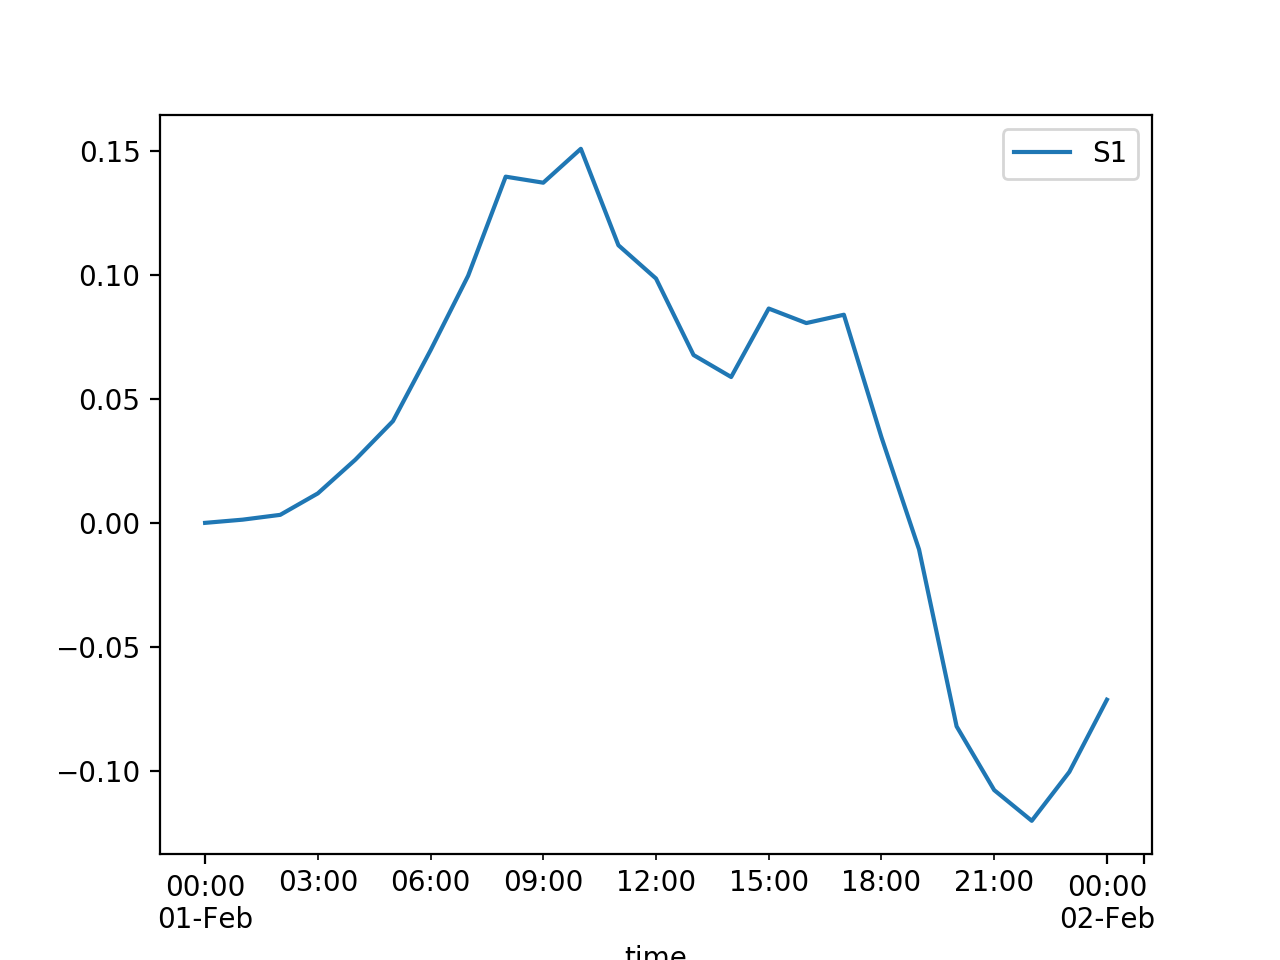

In [62]:
ts.S1.plot()

### compare all time series

<IPython.core.display.Javascript object>


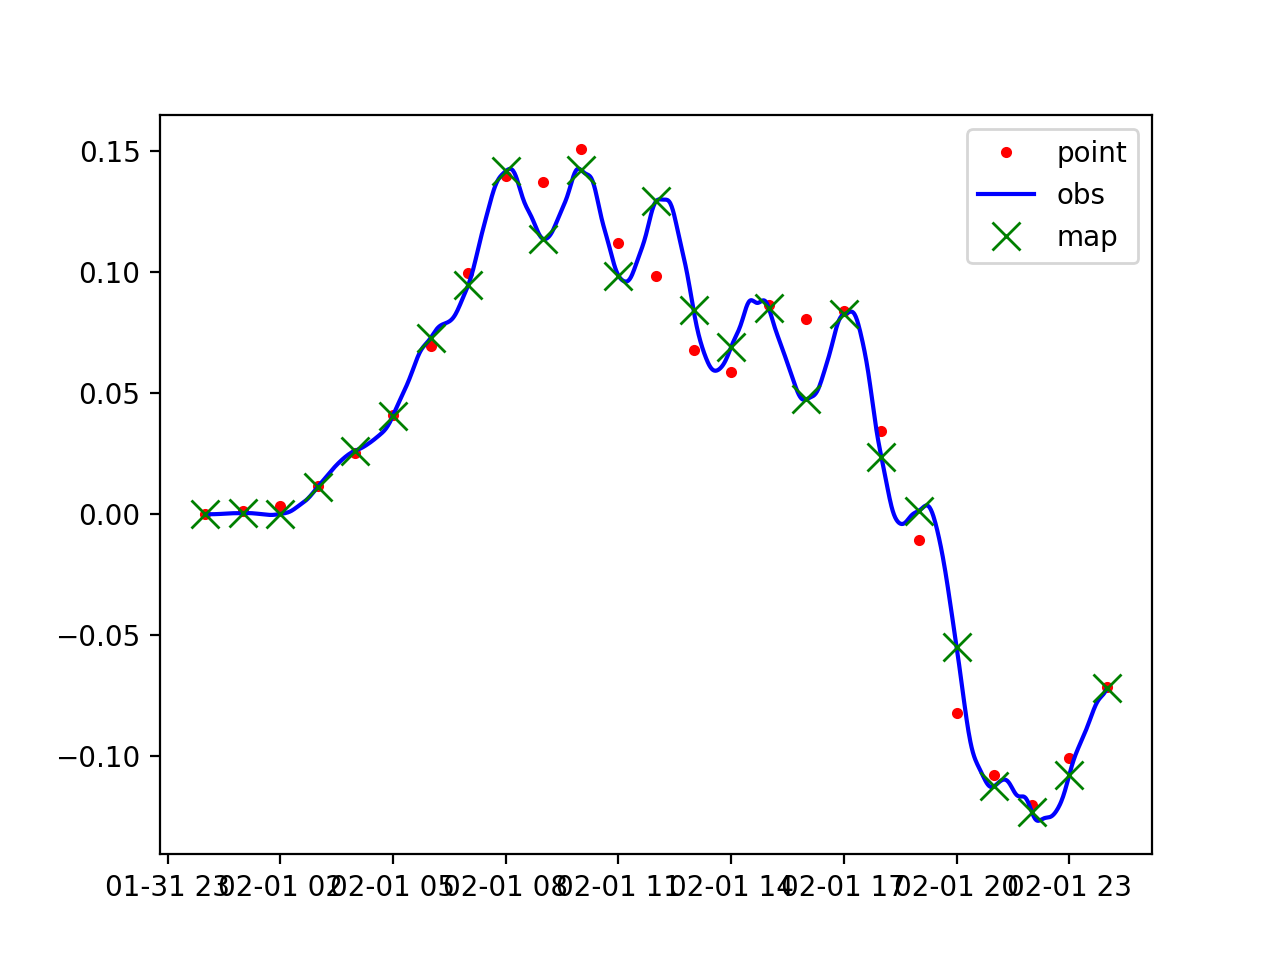

In [63]:
## Join the graphs
plt.figure()
plt.plot(ts.S1.index,ts.S1.values, marker='o', markersize=3, color='r', linestyle='None')
plt.plot(trih.ZWL[:,0].time,trih.ZWL[:,0].values ,color='b')

plt.plot(v.time,v.values ,marker='x', markersize=10, color='g', linestyle='None')


plt.legend(['point'] + ['obs'] + ['map'],loc='best')#,bbox_to_anchor=(1.1, 0.5))